In [1]:
import pandas as pd
import numpy as np

from scripts.pre_process_dataset import PreProcess
from scripts.import_dataset import ImportDataset
from scripts.plots import PlotReport

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
# mpl.rcParams["text.usetex"] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 16

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

[nltk_data] Downloading package wordnet to /home/dip07/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/dip07/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-11-29 22:34:34.935076: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-29 22:34:34.974678: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-29 22:34:35.979198: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical r

In [2]:
data = ImportDataset()
df = data.read_dataset()
print(f"✅ Combined dataset size: {df.shape[0]} samples")

✅ Combined dataset size: 14438 samples


In [3]:
clean_df = PreProcess(df)
df = clean_df.preprocess_dataset()
df.head(1)

,condition_label,medical_abstract
0,0,tissue change around loose prosthesis canine m...


In [4]:
X = df['medical_abstract']
y = df['condition_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_test.shape[0]}")

Training set size: 10106
Validation set size: 4332


In [5]:
# Settings
MAX_WORDS = 5000
MAX_LEN = 200

# Tokenize
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')


# Class weights
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights_array[i] for i in range(5)}
print(f"Vocab: {MAX_WORDS}, Max Length: {MAX_LEN}")
print(f"Train shape: {X_train_pad.shape}")

Vocab: 5000, Max Length: 200
Train shape: (10106, 200)


# Build, Train, and Evaluate LSTM Model


In [6]:
# Build LSTM
model_lstm = Sequential([
    Embedding(MAX_WORDS, 64, input_length=MAX_LEN),
    LSTM(32, return_sequences=True, dropout=0.2),
    GlobalMaxPooling1D(),
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model_lstm.compile(
    optimizer=keras.optimizers.Adam(0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_lstm = model_lstm.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    verbose=1
)

# Evaluate
# y_pred_lstm = np.argmax(model_lstm.predict(X_test_pad, verbose=0), axis=1)
# acc_lstm = accuracy_score(y_test, y_pred_lstm)
# print(f"\nLSTM Accuracy: {acc_lstm:.4f} ({acc_lstm*100:.2f}%)")


2025-11-29 22:34:48.604184: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - accuracy: 0.2935 - loss: 1.7325 - val_accuracy: 0.3719 - val_loss: 1.6524
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - accuracy: 0.3937 - loss: 1.5520 - val_accuracy: 0.4352 - val_loss: 1.4515
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.4296 - loss: 1.4258 - val_accuracy: 0.4387 - val_loss: 1.3259
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.5005 - loss: 1.3128 - val_accuracy: 0.4585 - val_loss: 1.3027
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 0.5418 - loss: 1.2215 - val_accuracy: 0.5153 - val_loss: 1.2224
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.5719 - loss: 1.1485 - val_accuracy: 0.5129 - val_loss: 1.2010
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.5767 - loss: 1.0924 - val_accuracy: 0.5109 - val_loss: 1.1986
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - accuracy: 0.5913 - loss: 1

In [7]:
loss, acc = model_lstm.evaluate(X_test_pad, y_test)
print("Accuracy:", acc)

136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.5420 - loss: 1.2739
Accuracy: 0.5420129299163818


# Classification Reports of the RNN Models

136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.47      0.46      1468
           1       0.68      0.68      0.68       928
           2       0.43      0.25      0.32       428
           3       0.47      0.23      0.31       552
           4       0.60      0.83      0.70       956

    accuracy                           0.54      4332
   macro avg       0.52      0.49      0.49      4332
weighted avg       0.53      0.54      0.52      4332



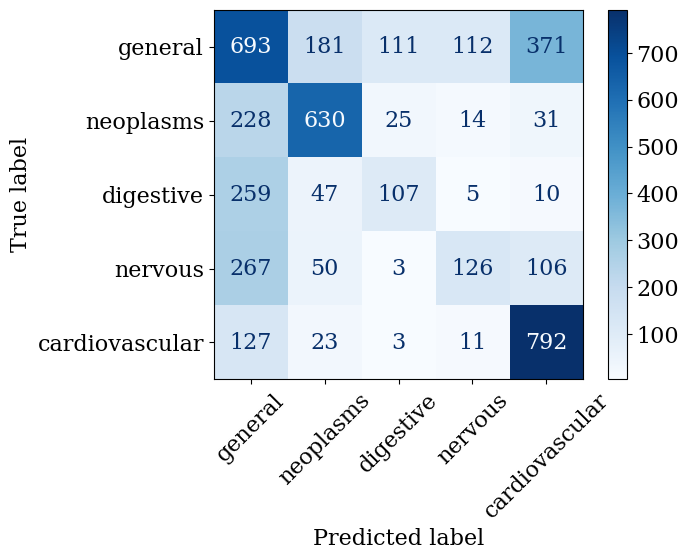

In [8]:
# Classification report for LSTM
# print("\n LSTM Classification Report ")
# print(classification_report(y_test, y_pred_lstm, target_names=[f'class_{i}' for i in range(5)]))

plot = PlotReport(model_lstm, X_test_pad, y_test)
plot.get_confusion_matrix(True)
plot.print_confusion_matrix("Confusion_RNN.pdf")

# Visualize Model Performance and Training Results


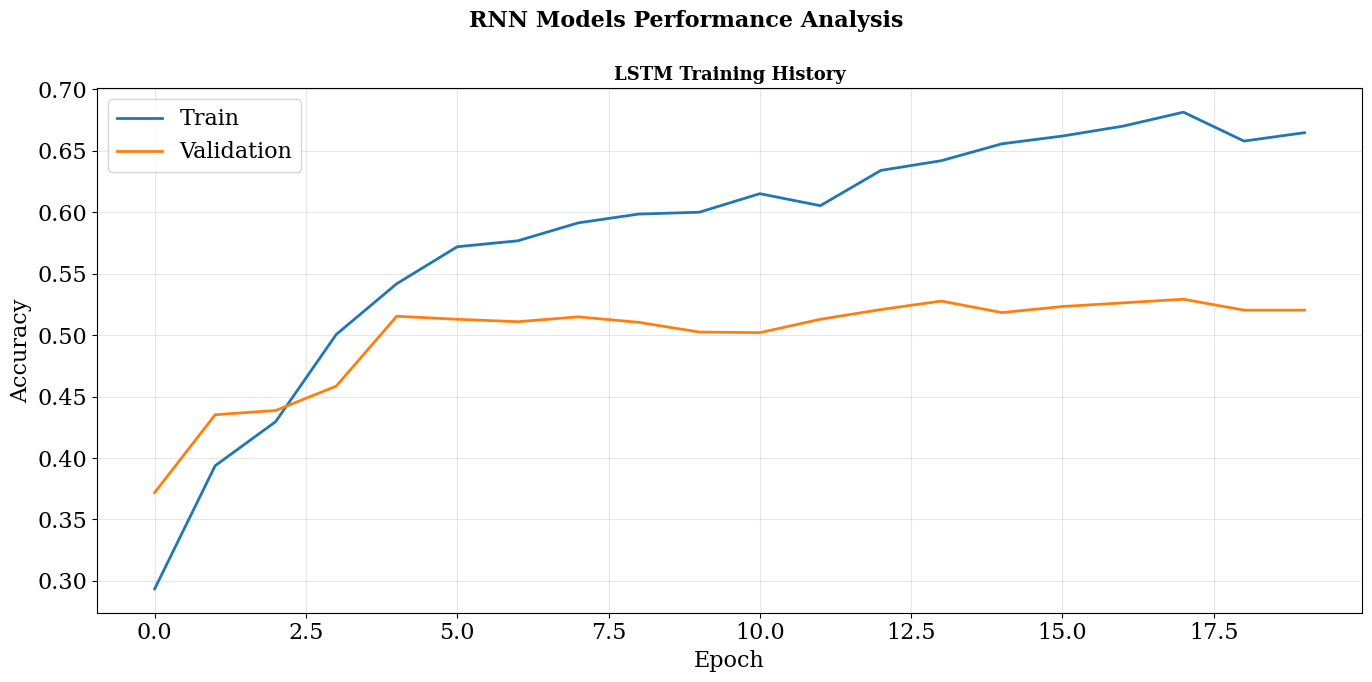

In [17]:
# Graph 1: Model Comparison
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(history_lstm.history['accuracy'], label='Train', linewidth=2)
ax.plot(history_lstm.history['val_accuracy'], label='Validation', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('LSTM Training History', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)


plt.suptitle('RNN Models Performance Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [10]:
df_labels = pd.read_csv("data/medical_tc_labels.csv")
df_labels.loc[df_labels['condition_label'] == 5, 'condition_label'] = 0
df_labels['name'] = df_labels['condition_name'].str.split(n=1, expand=True)[0]
df_labels = df_labels.sort_values(by='condition_label')
df_labels

,condition_label,condition_name,name
4,0,general pathological conditions,general
0,1,neoplasms,neoplasms
1,2,digestive system diseases,digestive
2,3,nervous system diseases,nervous
3,4,cardiovascular diseases,cardiovascular
